  <div class="abstract">This note explains stochastic variational inference from the ground up using the Pyro probabilistic programming language. I explore the basics of probabilistic programming and the machinery underlying SVI, such as autodifferentiation, guide functions, and approximating the difference between probability distributions.</div>
  <p>This note provides an introduction to probabilistic programming and variational inference using <a href="http://pyro.ai/">Pyro</a>. The Pyro website also has a <a href="http://pyro.ai/examples/intro_part_i.html">great tutorial</a>, but it’s distinctly oriented more towards people with probability backgrounds than systems backgrounds. If you, like me, are good at software engineering and bad at probability (single-letter variables in particular), then this note is for you.</p>

<p>The pedagogy here is to use small code samples to run experiments that slowly build intuition for how the system works. The beauty of having a programming language, as opposed to learning from a probability textbook/class, is that we can turn questions into executable programs and see if reality matches our expectations. The ultimate goal is that you will have an end-to-end understanding of variational inference for simple probabilistic inference problems.</p>

<p>I highly recommend you follow along in a Jupyter notebook. Tweak parameters, ask questions, and stay engaged! You can use the notebook in the accompanying repository here: <a href="https://github.com/willcrichton/pyro-under-the-hood">https://github.com/willcrichton/pyro-under-the-hood</a></p>

<h2 id="probabilistic-programs-and-distributions">Probabilistic programs and distributions</h2>

<p>A probabilistic program is a program that samples from probability distributions. For example:</p>

In [1]:
import pyro.distributions as dist
from pyro import sample
from torch import tensor

# A fair coin
coinflip = sample("coinflip", dist.Bernoulli(probs=0.5))
print('coinflip', coinflip)

# A noisy sample
noisy_sample = sample("noisy_sample", dist.Normal(loc=0, scale=1))
print('noisy_sample', noisy_sample)

coinflip tensor(0.)
noisy_sample tensor(0.8062)


<p>A probability distribution has two key functions: <code class="highlighter-rouge">sample</code>, which returns a single value in accordance with its probability (e.g. above, 0 and 1 are equally likely from the coin flip), and <code class="highlighter-rouge">log_prob</code>, which returns the log probability of a sample under the model.</p>

<blockquote>
  <p>Aside: Instead of doing <code class="highlighter-rouge">dist.sample</code>, we use <code class="highlighter-rouge">sample(name, dist)</code> for reasons you’ll see in a bit.</p>
</blockquote>

In [2]:
# Evaluating probability of values under distributiosn
print('X ~ B(0.5), P(X = 0): {:.2f}'.format(
    dist.Bernoulli(0.5).log_prob(tensor(0.)).exp()))
print('X ~ N(0, 1), P(X = 0.35): {:.2f}'.format(
    dist.Normal(0, 1).log_prob(tensor(0.35)).exp()))

X ~ B(0.5), P(X = 0): 0.50
X ~ N(0, 1), P(X = 0.35): 0.38


<p>By sampling from many distributions, we can describe a probabilistic generative model. As a running example, consider this <code class="highlighter-rouge">sleep_model</code> that describes the likely number of hours I’ll sleep on a given day. It generates a single data point by running the function top to bottom as a normal program.</p>

In [3]:
def sleep_model():
    # Very likely to feel lazy
    feeling_lazy = sample("feeling_lazy", dist.Bernoulli(0.9))
    if feeling_lazy:
        # Only going to (possibly) ignore my alarm if I'm feeling lazy
        ignore_alarm = sample("ignore_alarm", dist.Bernoulli(0.8))
        # Will sleep more if I ignore my alarm
        amount_slept = sample("amount_slept",
                              dist.Normal(8 + 2 * ignore_alarm, 1))
    else:
        amount_slept = sample("amount_slept", dist.Normal(6, 1))
    return amount_slept

print(sleep_model())
print(sleep_model())
print(sleep_model())

tensor(8.6401)
tensor(8.8105)
tensor(9.7322)


<blockquote>
  <p>Aside: This is called a “generative” model because it has an explicit probabilistic model for every random variable (e.g. the prior on <code class="highlighter-rouge">feeling_lazy</code>). By contrast, a “discriminative” model only tries to model a conditional probabilistic distribution, where given some observations, you predict the distribution over unobserved variables.</p>
</blockquote>

<p>At this point, our stochastic functions are nothing special, as in they do not need any specialized system or machinery to work. It’s mostly just normal Python. For example, we could implement one of these distributions ourselves:</p>

In [5]:
from random import random

class Bernoulli:
    def __init__(self, p):
        self.p = p
        
    def sample(self):
        # random() is uniform between [0, 1]
        if random() < self.p:
            return tensor(1.)
        else:
            return tensor(0.)
        
    def log_prob(self, x):
        # This formulation is differentiable!
        return (x * self.p + (1 - x) * (1 - self.p)).log()
    
b = Bernoulli(0.8)
print('x ~ P_b:', b.sample())
print('P_b(0):', b.log_prob(tensor(0.)).exp())

x ~ P_b: tensor(0.)
P_b(0): tensor(0.2000)


<h2 id="traces-and-conditioning">Traces and conditioning</h2>

<p>On the unconditional sleep model, we could ask a few questions, like:</p>
<ul>
  <li>Joint probability of a sample: what is the probability that <code class="highlighter-rouge">feeling_lazy = 1, ignore_alarm = 0, amount_slept = 10</code>?</li>
  <li>Joint probability distribution: what is the probability for any possible assignment to all variables?</li>
  <li>Marginal probability of a sample: what is the probability that <code class="highlighter-rouge">feeling_lazy</code> is true?</li>
  <li>Marginal probability distribution: what is the probability over all values of <code class="highlighter-rouge">amount_slept</code>?</li>
</ul>

<p>First, we need the ability to evaluate the probability of a joint assignment to each variable.</p>

In [7]:
from pyro.poutine import trace
from pprint import pprint

# Runs the sleep model once and collects a trace
tr = trace(sleep_model).get_trace()

pprint({
    name: {
        'value': props['value'],
        'prob': props['fn'].log_prob(props['value']).exp()
    }
    for (name, props) in tr.nodes.items()
    if props['type'] == 'sample'
})

print(tr.log_prob_sum().exp()) 

{'amount_slept': {'prob': tensor(0.2528), 'value': tensor(5.0447)},
 'feeling_lazy': {'prob': tensor(0.1000), 'value': tensor(0.)}}
tensor(0.0253)


<p>Here, the <code class="highlighter-rouge">trace</code> feature will collect values every time they are sampled with <code class="highlighter-rouge">sample</code> and store them with the corresponding string name (that’s why we give each sample a name). With a little cleanup, we can print out the value and probability of each random variable’s value, along with the joint probability of the entire trace.</p>

<blockquote>
  <p>From a software engineering and PL perspective, the ability to do things like wrap a function with <code class="highlighter-rouge">trace</code> and collect its samples (called “effect handling”) is the core functionality of a probabilistic programming language like Pyro. Most of the remaining magic is in the automatic differentiation (in PyTorch) that we’ll see later. I highly recommend reading the <a href="https://github.com/pyro-ppl/pyro/blob/dev/pyro/contrib/minipyro.py">Mini Pyro</a> implementation to see how to design a modular effects system. For this note, it suffices to know that the <code class="highlighter-rouge">sample</code> mechanism enables an external entity calling the model function to observe and modify its execution.</p>
</blockquote>

<p>The code above randomly generates a trace and shows its probability, but we want to compute the probability of a pre-selected set of values. For that, we can use <code class="highlighter-rouge">condition</code>:</p>

In [8]:
from pyro import condition

cond_model = condition(sleep_model, {
    "feeling_lazy": tensor(1.),
    "ignore_alarm": tensor(0.),
    "amount_slept": tensor(10.)
})

trace(cond_model).get_trace().log_prob_sum().exp()

tensor(0.0097)

<p>Here, <code class="highlighter-rouge">condition</code> means “force the sample to return the provided value, and compute the trace probability as if that value was sampled.” So for example, forcing <code class="highlighter-rouge">feeling_lazy</code> to <code class="highlighter-rouge">1</code> means the trace starts with probability <code class="highlighter-rouge">0.9</code>. This also means the if statement will always go down the first branch. Inuitively, this particular choice should have low probability because if we didn’t ignore our alarm, then <code class="highlighter-rouge">amount_slept</code> should be closer to 8, not 10. That’s reflected in the low joint probability of 0.0097.</p>

<p>Now, we can produce an approximate answer to any of our questions above by sampling from the distribution enough times. For example, we can look at the marginal distribution over each variable:</p>

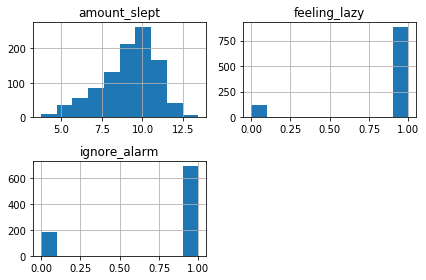

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

traces = []
for _ in range(1000):
    tr = trace(sleep_model).get_trace()
    values = {
        name: props['value'].item()
        for (name, props) in tr.nodes.items()
        if props['type'] == 'sample'
    }
    traces.append(values)

pd.DataFrame(traces).hist()
plt.tight_layout()

<p>Look at each histogram and see if its distribution matches your expectations given the code for <code class="highlighter-rouge">sleep_model</code>. For example, the <code class="highlighter-rouge">feeling_lazy</code> histogram is true (or 1) about 90% of the time, which matches the prior belief <code class="highlighter-rouge">Bernoulli(0.9)</code>.</p>

<h2 id="sampling-conditional-distributions">Sampling conditional distributions</h2>

<p>Here’s a few more questions we might want to answer.</p>
<ul>
  <li>Given I slept 6 hours, what is the probability I was feeling lazy?</li>
  <li>What is the probability of me sleeping exactly 7.65 hours?</li>
</ul>

<p>These are conditional probability questions, meaning they ask: given a particular value of some of the random variables, what are the likely values for the other random variables? The probability folk tend to call these “observed” and “latent” variables (often denoted by X and Z), respectively. A common use case for generative models is that the generated object is the thing you observe in the real world (like an image), and you want to guess the values of unobserved variables given that observation (like whether the image is a cat or a dog).</p>

<blockquote>
  <p>Aside: the second question is not obviously a conditional one. But to answer it, we need to compute <script type="math/tex">P(\text{feeling lazy}, \text{ignore alarm} \mid \text{amount slept})</script>. See my <a href="https://forum.pyro.ai/t/marginal-probability-of-single-assignment-to-multiple-variables/1031/3">Pyro forum post</a> for why.</p>
</blockquote>

<p>For example, a smart watch can probably record my sleep patterns, but not record whether I was being lazy. So in the sleep model, we could say <code class="highlighter-rouge">amount_slept</code> is an observed random variable while <code class="highlighter-rouge">feeling_lazy</code> and <code class="highlighter-rouge">ignore_alarm</code> are latent random variables. Applying some basic probability theory, we can write out the quantity we want to compute:</p>

<script type="math/tex; mode=display">% <![CDATA[
\begin{align*}
&P(\text{feeling lazy} = T \mid \text{amount slept} = 6) \\
=&\frac{P(\text{feeling lazy} = T, \text{amount slept} = 6)}{P(\text{amount slept} = 6)} \\
=&\frac{\sum_{ia \in \{T, F\}} P(\text{feeling lazy} = T, \text{amount slept} = 6, \text{ignore alarm} = ia)}{\sum_{(ia, fl) \in \{T, F\}^2} P(\text{feeling lazy} = fl, \text{amount slept} = 6, \text{ignore alarm} = ia)}
\end{align*} %]]></script>

<p>Why did we rewrite the probability this way? Remember that with the unconditioned generative model, it’s easy for us to compute the probability of a joint assignment to <em>every</em> variable. So we can compute the probability of a single variable (a “marginal” probability), e.g. <script type="math/tex">P(\text{amount slept} = 6)</script>, as a sum over joint probabilities.</p>

<p>However, there are two problems with this approach. First, as the number of marginalized variables grows, we have an exponential increase in summation terms. In some cases, this issue can be addressed using algorithmic techniques like dynamic programming for <a href="https://ermongroup.github.io/cs228-notes/inference/ve/">variable elimination</a> in the case of discrete variables. But the second issue is that for continuous variables, computing this marginal probability can quickly become intractable. For example, if <code class="highlighter-rouge">feeling_lazy</code> was a real-valued laziness score between 0 and 1 (presumably a more realistic model), then marginalizing that variable requires an integral instead of a sum. In general, producing an exact estimate of a conditional probability for a complex probabilistic program is not computationally feasible.</p>

<h2 id="approximate-inference">Approximate inference</h2>

<p>The main idea is that instead of exactly computing the conditional probability distribution (or “posterior”) of interest, we can approximate it using a variety of techniques. Generally, these fall into two camps: sampling methods and variational methods. The CS 228 (Probabilistic Graphical Models at Stanford) course notes go in depth on both (<a href="https://ermongroup.github.io/cs228-notes/inference/sampling/">sampling</a>, <a href="https://ermongroup.github.io/cs228-notes/inference/variational/">variational</a>). Essentially, for sampling methods, you use algorithms that continually draw samples from a changing probability distribution until eventually they converge on the true posterior of interest. The time to convergence is not known ahead of time. For variational methods, you use a simpler function that can be optimized to match the true posterior using standard optimization techniques like gradient descent.</p>

<p>How do you know which kind to use for a given probabilistic model? This <a href="https://stats.stackexchange.com/a/271862">StackOverflow</a> answer highlights when it makes sense to use one vs. another (in summary: sampling for small data and when you <em>really</em> care about accuracy, variational otherwise). This note from <a href="http://dustintran.com/blog/on-pyro-deep-probabilistic-programming-on-pytorch">Dustin Tran</a>, a developer of the Edward PPL, highlights which kinds of inference PPLs beyond Pyro are generally used for.</p>

<p>As for Pyro, the <a href="https://eng.uber.com/pyro/">introductory blog post</a> and this <a href="https://www.youtube.com/watch?v=crvNIGyqGSU&amp;feature=youtu.be">PROBPROG’18 keynote</a> provide a high-level motivation for Pyro’s focus on variational inference. One high-level theme is bringing Bayesian reasoning (i.e. quantifying uncertainty) to deep neural nets. Pyro’s integration with PyTorch is meant to facilitate the use of probabilistic programming techniques with standard neural nets. For example, one use case I heard of was using DNNs for 3D reconstruction from video, but augmenting the training process with probabilistic priors that use domain knowledge, e.g. if I’m reconstructing a stop sign, it should be close to an intersection.</p>

<p>That said, the space is still wide open, and researchers are working hard to develop new applications on top of these technologies. I recommend looking at the <a href="https://probprog.cc/schedule/">PROBPROG’18</a> talks to get a more general sense of PPL applications if you’re interested.</p>

<h2 id="variational-inference-1-autodifferentiation">Variational inference 1: autodifferentiation</h2>

<p>Since Pyro’s stake in the ground is on variational inference, let’s explore all the mechanics underneath it. For starters, we need to understand autodifferentiation, gradients, and backpropagation in PyTorch. Let’s say I have an extremely simple model that just samples a normal distribution with fixed parameters:</p>

In [11]:
norm = dist.Normal(0, 1)
x = sample("x", norm)
print(x)

tensor(0.8189)


In [12]:
from pyro import param

mu = param("mu", tensor(0.))
norm = dist.Normal(mu, 1)
x = sample("x", norm)
print(mu, x)

tensor(0., requires_grad=True) tensor(-0.8586, grad_fn=<AddBackward0>)


In [13]:
prob = norm.log_prob(5)
print('Initial prob:', prob, prob.exp())

prob.backward() # Compute gradients with respect to probability

print('mu:', mu)
print('d mu / d prob:', mu.grad) # 5.0
mu.data += mu.grad # Manually take gradient step

print('Final prob:', dist.Normal(mu, 1).log_prob(5).exp()) 
print('Final mu:', mu)

Initial prob: tensor(-13.4189, grad_fn=<SubBackward0>) tensor(1.4867e-06, grad_fn=<ExpBackward>)
mu: tensor(0., requires_grad=True)
d mu / d prob: tensor(5.)
Final prob: tensor(0.3989, grad_fn=<ExpBackward>)
Final mu: tensor(5., requires_grad=True)


In [14]:
from pyro import clear_param_store

# Note: params are persistent, so we have to manually reset the global Pyro parameter store
# to avoid caching results between experiments
clear_param_store()

def model():
    mu = param("mu", tensor(0.))
    return sample("x", dist.Normal(mu, 1))

cond_model = condition(model, {"x": 5})
tr = trace(cond_model).get_trace()
tr.log_prob_sum().backward()

mu = param("mu")
mu.data += mu.grad
print('Final mu:', mu)

Final mu: tensor(5., requires_grad=True)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7facce857588>,
      dtype=object)

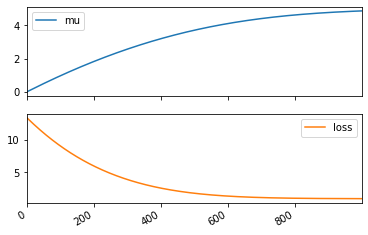

In [15]:
from torch.optim import Adam

clear_param_store()

def model():
    mu = param("mu", tensor(0.))
    return sample("x", dist.Normal(mu, 1))

model() # Instantiate the mu parameter
cond_model = condition(model, {"x": 5})

# Large learning rate for demonstration purposes
optimizer = Adam([param("mu")], lr=0.01)
mus = []
losses = []
for _ in range(1000):
    tr = trace(cond_model).get_trace()

    # Optimizer wants to push positive values towards zero,
    # so use negative log probability
    prob = -tr.log_prob_sum()
    prob.backward()

    # Update parameters according to optimization strategy
    optimizer.step()

    # Zero all parameter gradients so they don't accumulate
    optimizer.zero_grad()

    # Record probability (or "loss") along with current mu
    losses.append(prob.item())
    mus.append(param("mu").item())

pd.DataFrame({"mu": mus, "loss": losses}).plot(subplots=True)

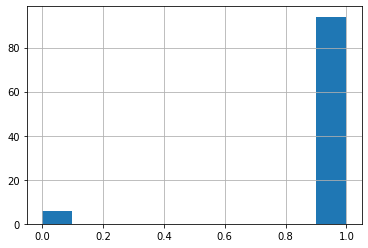

In [16]:
# Condition model on observed data
underslept = condition(sleep_model, {"amount_slept": 6.})

# Draw samples from conditioned model?
pd.Series(
    [trace(underslept).get_trace().nodes['feeling_lazy']['value'].item()
    for _ in range(100)]) \
    .hist()

In [17]:
def sleep_guide():
    sample("feeling_lazy", dist.Delta(tensor(1.)))
    sample("ignore_alarm", dist.Delta(tensor(0.)))

trace(sleep_guide).get_trace().nodes['feeling_lazy']['value']

tensor(1.)

In [18]:
import torch

def elbo(guide, cond_model):
    dist = 0.
    for fl in [0., 1.]:
        for ia in [0., 1.] if fl == 1. else [0.]:
            log_prob = lambda f: trace(condition(
                f, {"feeling_lazy": tensor(fl), "ignore_alarm": tensor(ia)})) \
                .get_trace().log_prob_sum()
            guide_prob = log_prob(guide)
            cond_model_prob = log_prob(cond_model)
            term = guide_prob.exp() * (cond_model_prob - guide_prob)
            if not torch.isnan(term):
                dist += term
    return dist

elbo(sleep_guide, underslept)

tensor(-4.6337)

In [19]:
def sleep_guide2():
    sample("feeling_lazy", dist.Delta(tensor(0.)))
    sample("ignore_alarm", dist.Delta(tensor(0.)))

elbo(sleep_guide2, underslept)

tensor(-3.2215)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7facce9c5fd0>,
      dtype=object)

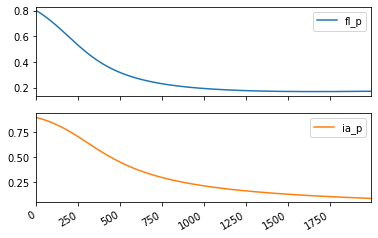

In [20]:
from torch.distributions import constraints
clear_param_store()

def sleep_guide():
    # Constraints ensure facts always remain true during optimization,
    # e.g. that the parameter of a Bernoulli is always between 0 and 1
    valid_prob = constraints.interval(0., 1.)
    fl_p = param('fl_p', tensor(0.8), constraint=valid_prob)
    ia_p = param('ia_p', tensor(0.9), constraint=valid_prob)
    feeling_lazy = sample('feeling_lazy', dist.Bernoulli(fl_p))

    # Consistent with the model, we only sample ignore_alarm if
    # feeling_lazy is true
    if feeling_lazy == 1.:
        sample('ignore_alarm', dist.Bernoulli(ia_p))
sleep_guide()

adam = Adam([param('fl_p').unconstrained(), param('ia_p').unconstrained()],
            lr=0.005, betas=(0.90, 0.999))
param_vals = []

for _ in range(2000):
    # We can use our elbo function from earlier and compute its gradient
    loss = -elbo(sleep_guide, underslept)
    loss.backward()

    adam.step()
    adam.zero_grad()

    param_vals.append({k: param(k).item() for k in ['fl_p', 'ia_p']})

pd.DataFrame(param_vals).plot(subplots=True)

In [21]:
from pyro.poutine import replay

def elbo_approx(guide, cond_model):
    guide_trace = trace(guide).get_trace()
    model_trace = trace(replay(cond_model, guide_trace)).get_trace()
    return model_trace.log_prob_sum() - guide_trace.log_prob_sum()

In [22]:
def optimize_guide(elbo):
    clear_param_store()
    sleep_guide()

    adam = Adam([param('fl_p').unconstrained(), param('ia_p').unconstrained()],
                lr=0.005, betas=(0.90, 0.999))
    param_vals = []
    grad_vals = []

    for _ in range(2000):
        # We can use our elbo function from earlier and compute its gradient
        loss = -elbo(sleep_guide, underslept)
        loss.backward()
        grad_vals.append(param('fl_p').unconstrained().grad.item())

        adam.step()
        adam.zero_grad()

        param_vals.append({k: param(k).item() for k in ['fl_p', 'ia_p']})
        
    return param_vals, grad_vals

Parameters for true ELBO


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7facccf2c908>,
      dtype=object)

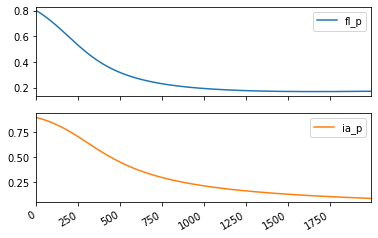

In [23]:
true_param_vals, true_grad_vals = optimize_guide(elbo)
print('Parameters for true ELBO')
pd.DataFrame(true_param_vals).plot(subplots=True)

Gradient for true ELBO


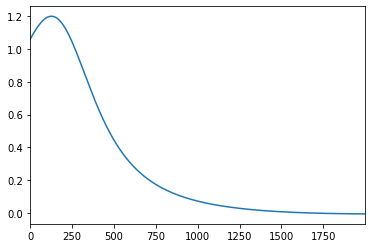

In [24]:
print('Gradient for true ELBO')
pd.Series(true_grad_vals).plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7facce86f7b8>,
      dtype=object)

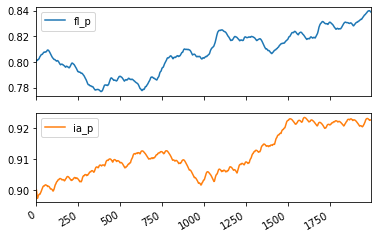

In [25]:
approx_param_vals, approx_grad_vals = optimize_guide(elbo_approx)
pd.DataFrame(approx_param_vals).plot(subplots=True)

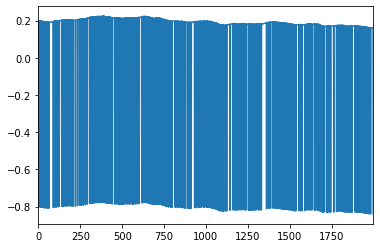

In [26]:
pd.Series(approx_grad_vals).plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faccea50400>,
      dtype=object)

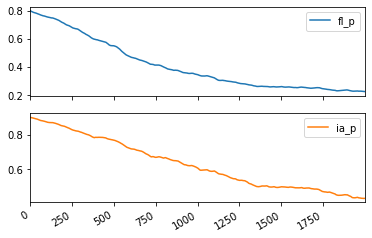

In [27]:
def elbo_better_approx(guide, cond_model):
    guide_trace = trace(guide).get_trace()
    model_trace = trace(replay(cond_model, guide_trace)).get_trace()
    elbo = model_trace.log_prob_sum() - guide_trace.log_prob_sum()
    # "detach" means "don't compute gradients through this expression"
    return guide_trace.log_prob_sum() * elbo.detach() + elbo

better_approx_param_vals, better_approx_grad_vals = optimize_guide(elbo_better_approx)
pd.DataFrame(better_approx_param_vals).plot(subplots=True)

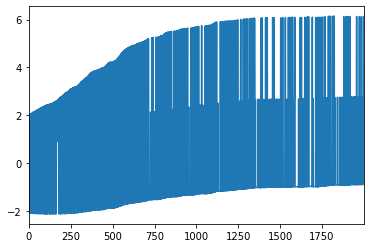

In [28]:
pd.Series(better_approx_grad_vals).plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7facccd19908>,
      dtype=object)

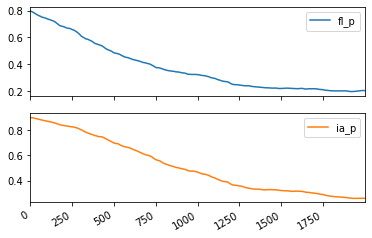

In [29]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

clear_param_store()
adam = Adam({"lr": 0.005, "betas": (0.90, 0.999)})
svi = SVI(underslept, sleep_guide, adam, loss=Trace_ELBO())

param_vals = []
for _ in range(2000):
    svi.step()
    param_vals.append({k: param(k).item() for k in ["fl_p", "ia_p"]})

pd.DataFrame(param_vals).plot(subplots=True)

In [31]:
clear_param_store()

def sleep_guide_delta():
    is_bool = constraints.boolean
    fl = param('fl_p', tensor(1.0), constraint=is_bool)
    ia = param('ia_p', tensor(0.0), constraint=is_bool)
    feeling_lazy = sample("feeling_lazy", dist.Delta(fl))
    if feeling_lazy == 1.0:
        sample("ignore_alarm", dist.Delta(ia))

svi = SVI(underslept, sleep_guide_delta, adam, loss=Trace_ELBO())
svi.step() # NotImplementedError: Cannot transform _Boolean constraints

NotImplementedError: Cannot transform _Boolean constraints
Trace Shapes:
 Param Sites:
Sample Sites: